### Does CellariumGPT recapitulate empirical mean for a given cell type?

Can we turn this into a quantitative benchmark?

In [1]:
import os
import torch
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

sc.set_figure_params(figsize=(4, 4))

DEVICE = torch.device('cuda:0')

from cellarium.ml.utilities.inference.cellarium_gpt_inference import \
    CellariumGPTInferenceContext, \
    GeneNetworkAnalysisBase

# reset matplotlib params


In [65]:
ROOT_PATH = "/home/mehrtash/data"
# CHECKPOINT_PATH = "/home/mehrtash/data/100M_long_run/run_001/lightning_logs/version_3/checkpoints/epoch=5-step=504000.ckpt"
# CHECKPOINT_PATH = "/home/mehrtash/data/mb_checkpoints/10M_001_bs1536/epoch=1-step=29161__updated.ckpt"
# CHECKPOINT_PATH = "/home/mehrtash/data/mb_checkpoints/19M_001_bs2048/epoch=1-step=28244__updated.ckpt"
# CHECKPOINT_PATH = "/home/mehrtash/data/mb_checkpoints/30M_001_bs2560/epoch=2-step=43129__updated.ckpt"
# CHECKPOINT_PATH = "/home/mehrtash/data/mb_checkpoints/59M_001_bs3072/epoch=3-step=53770__updated.ckpt"
CHECKPOINT_PATH = "/home/mehrtash/data/mb_checkpoints/98M_001_bs4608/epoch=6-step=63560__updated.ckpt"

REF_ADATA_PATH = os.path.join(ROOT_PATH, "data", "extract_0.h5ad")
GENE_INFO_PATH = os.path.join(ROOT_PATH, "gene_info", "gene_info.tsv")

ctx = CellariumGPTInferenceContext(
    cellarium_gpt_ckpt_path=CHECKPOINT_PATH,
    ref_adata_path=REF_ADATA_PATH,
    gene_info_tsv_path=GENE_INFO_PATH,
    device=DEVICE,
    attention_backend="mem_efficient",
    verbose=False
)

In [66]:
# load validation cell type table
val_adata = sc.read_h5ad(
    os.path.join(ROOT_PATH, "data", "cellariumgpt_artifacts", "cell_types_for_validation_filtered.h5ad"))

In [67]:
val_adata

AnnData object with n_obs × n_vars = 61 × 28680
    obs: 'cell_type', 'assay', 'suspension_type', 'tissue', 'sex', 'disease', 'total_mrna_umis'
    var: 'feature_id', 'feature_name'

In [68]:
# shoow the full dataframe
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(val_adata.obs)

,cell_type,assay,suspension_type,tissue,sex,disease,total_mrna_umis
0,GABAergic neuron,10x 3' v3,nucleus,brain,male,normal,5527.708887
1,glutamatergic neuron,10x 3' v3,nucleus,brain,male,normal,10683.399862
2,astrocyte,10x 3' v3,nucleus,brain,male,normal,5380.963698
3,oligodendrocyte,10x 3' v3,nucleus,brain,male,normal,5083.603161
4,oligodendrocyte precursor cell,10x 3' v3,nucleus,brain,male,normal,6609.696174
5,microglial cell,10x 3' v3,nucleus,brain,male,normal,3645.962305
6,cerebellar granule cell,10x 3' v3,nucleus,brain,male,normal,3935.779702
7,endothelial cell,10x 3' v3,nucleus,brain,male,normal,3115.828938
8,classical monocyte,10x 5' v2,cell,blood,male,normal,3922.025000
9,non-classical monocyte,10x 5' v2,cell,blood,male,normal,8436.318182


In [69]:
val_cell_type_indices = [
    2,  # astro
    3,  # oligo
    5,  # microglia
    12, # CD8
    10, # NK
    22, # entero
    59  # cardiomyocyte
]

val_cell_type_names = [
    'astrocyte',
    'oligodendrocyte',
    'microglia',
    'CD8+ T cell',
    'NK',
    'enterocyte',
    'cardiomyocyte'
]

query_gene_ids = val_adata.var['feature_id'].values
query_gene_symbols = val_adata.var['feature_name'].values

In [70]:
model_X_ng = np.zeros((len(val_cell_type_indices), len(query_gene_ids)))

for n, val_cell_idx in enumerate(val_cell_type_indices):

    # arguments
    row = val_adata.obs.iloc[val_cell_idx]

    assay = row.assay
    suspension_type = row.suspension_type
    prompt_metadata_dict = {
        "cell_type": row.cell_type,
        "tissue": row.tissue,
        "disease": row.disease,
        "sex": row.sex,
    }
    total_mrna_umis = float(row.total_mrna_umis)

    query_chunk_size = 1_000
    max_counts = 500
    upper_percentile = 0.5  # doesn't matter, we only need the logits
    upper_pad = 1  # doesn't matter, we only need the logits

    gex_range_dict = ctx.predict_gene_expression_range_for_metadata(
        assay=assay,
        suspension_type=suspension_type,
        prompt_metadata_dict=prompt_metadata_dict,
        total_mrna_umis=total_mrna_umis,
        query_gene_ids=query_gene_ids,
        query_chunk_size=query_chunk_size,
        total_prob_mass=upper_percentile,
        symmetric_range_pad=upper_pad,
        max_counts=max_counts,
    )

    model_X_ng[n, :] = gex_range_dict['gene_marginal_mean_q'].cpu().numpy()

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

In [71]:
empirical_X_ng = val_adata.X[val_cell_type_indices, :].copy()

In [72]:
# renormalize
model_X_ng = 10_000 * model_X_ng / model_X_ng.sum(axis=1, keepdims=True)
empirical_X_ng = 10_000 * empirical_X_ng / empirical_X_ng.sum(axis=1, keepdims=True)

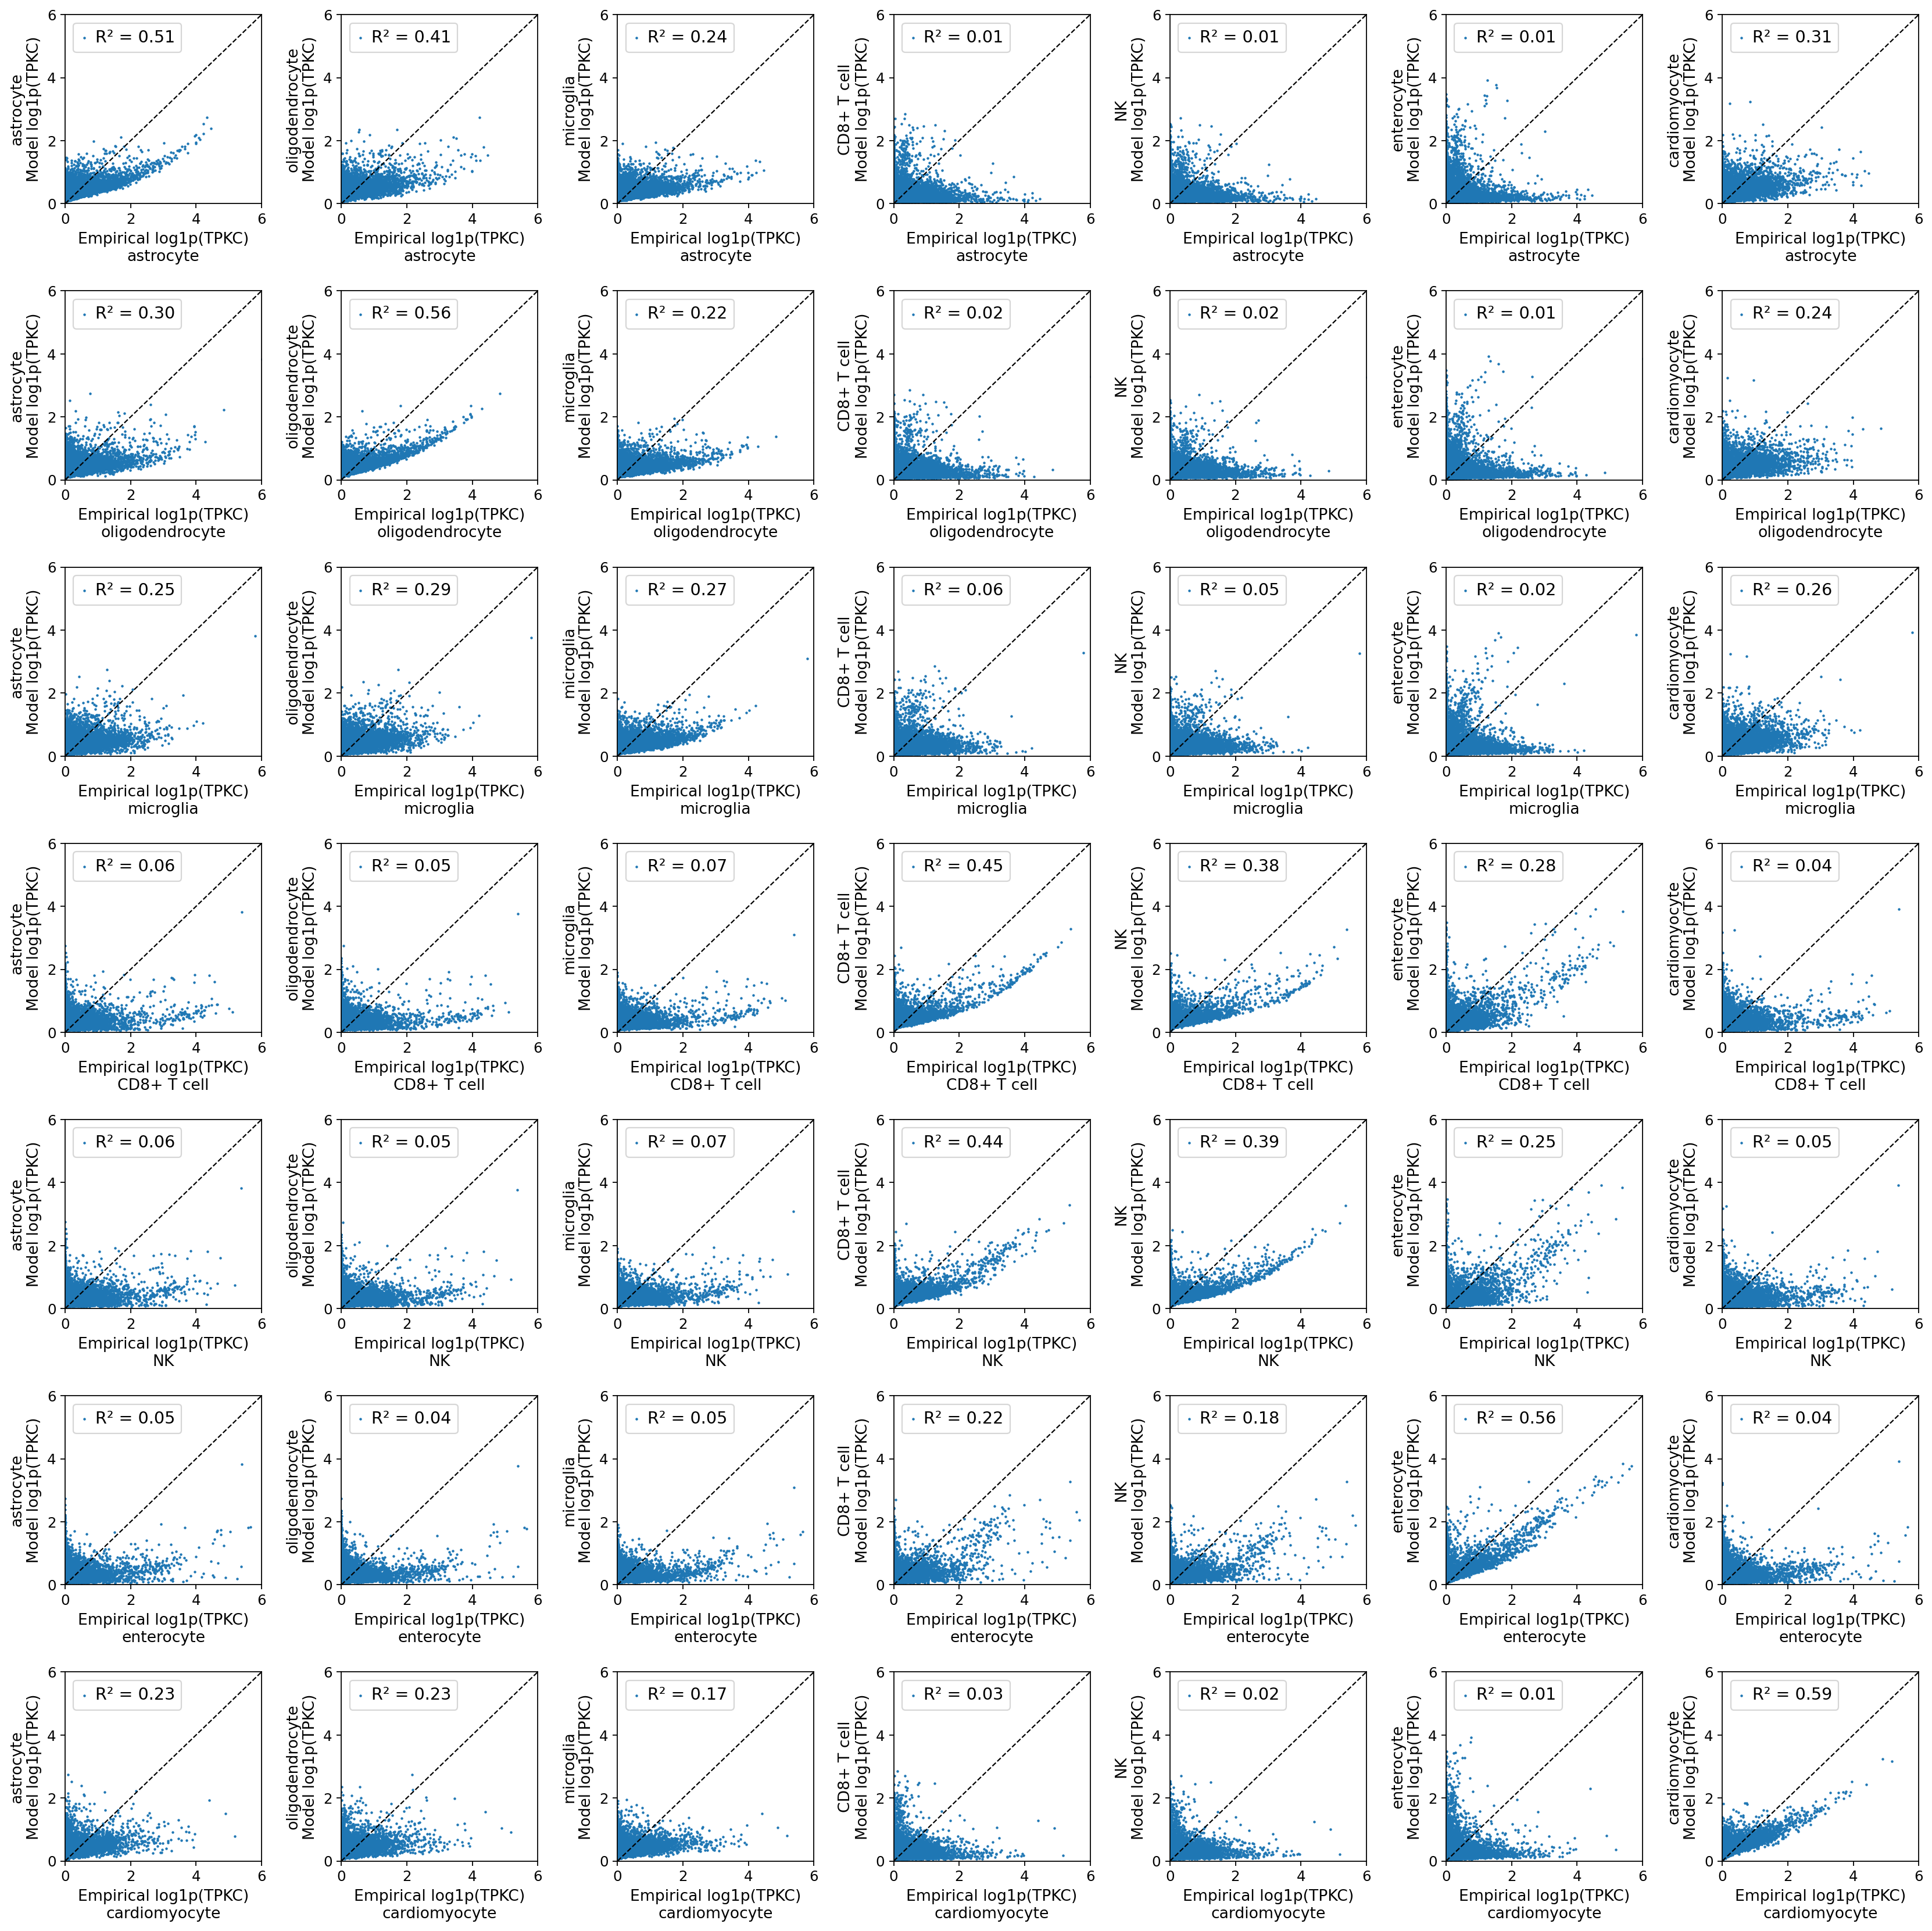

In [73]:
panel_size = 3
n_cells = len(val_cell_type_indices)

fig, axs = plt.subplots(ncols=n_cells, nrows=n_cells, figsize=(panel_size * n_cells, panel_size * n_cells))

for i in range(n_cells):
    for j in range(n_cells):

        ax = axs[i, j]

        x = np.log1p(empirical_X_ng[i, :])
        y = np.log1p(model_X_ng[j, :])

        # linear regression r-squared
        r_squared = np.corrcoef(x, y)[0, 1] ** 2

        ax.scatter(x, y, s=1, label=f"R² = {r_squared:.2f}")
        ax.legend(loc='upper left')

        ax.grid(False)
        ax.set_xlim((0, 6))
        ax.set_ylim((0, 6))
        ax.plot([0, 6], [0, 6], color='black', linestyle='--', linewidth=1)
        ax.set_xticks([0, 2, 4, 6])
        ax.set_yticks([0, 2, 4, 6])

        # reduce tick font size
        ax.tick_params(axis='both', which='major', labelsize=11)
        ax.set_xlabel(f"Empirical log1p(TPKC)\n{val_cell_type_names[i]}", fontsize=12)
        ax.set_ylabel(f"{val_cell_type_names[j]}\nModel log1p(TPKC)", fontsize=12)

fig.tight_layout()

#### How sensitive the model is to the total number of mRNA UMIs?

In [193]:
val_cell_type_indices = [
    2,  # astro
    3,  # oligo
    5,  # microglia
    12, # CD8
    10, # NK
    22, # entero
    59  # cardiomyocyte
]

val_cell_type_names = [
    'astrocyte',
    'oligodendrocyte',
    'microglia',
    'CD8+ T cell',
    'NK',
    'enterocyte',
    'cardiomyocyte'
]

total_mrna_umis_list = np.linspace(500, 40_000, 30)

query_gene_ids = val_adata.var['feature_id'].values
query_gene_symbols = val_adata.var['feature_name'].values

In [197]:
# empirical gene expression
empirical_X_ng = val_adata.X[val_cell_type_indices, :].copy()

# model gene expression
model_X_nmg = np.zeros((
    len(val_cell_type_indices),
    len(total_mrna_umis_list),
    len(query_gene_ids)))

for n in range(len(val_cell_type_indices)):

    # arguments
    row_index = val_cell_type_indices[n]
    row = val_adata.obs.iloc[row_index]

    assay = row.assay
    suspension_type = row.suspension_type
    prompt_metadata_dict = {
        "cell_type": row.cell_type,
        "tissue": row.tissue,
        "disease": row.disease,
        "sex": row.sex,
    }

    for m, total_mrna_umis in enumerate(total_mrna_umis_list):

        query_chunk_size = 1_000
        max_counts = 500
        upper_percentile = 0.5  # doesn't matter, we only need the logits
        upper_pad = 1  # doesn't matter, we only need the logits

        gex_range_dict = ctx.predict_gene_expression_range_for_metadata(
            assay=assay,
            suspension_type=suspension_type,
            prompt_metadata_dict=prompt_metadata_dict,
            total_mrna_umis=total_mrna_umis,
            query_gene_ids=query_gene_ids,
            query_chunk_size=query_chunk_size,
            total_prob_mass=upper_percentile,
            symmetric_range_pad=upper_pad,
            max_counts=max_counts,
        )

        model_X_nmg[n, m, :] = gex_range_dict['gene_marginal_mean_q'].cpu().numpy()

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

In [198]:
# renormalize to TPKC
empirical_X_ng = 10_000 * empirical_X_ng / empirical_X_ng.sum(axis=1, keepdims=True)
model_X_nmg = 10_000 * model_X_nmg / model_X_nmg.sum(axis=2, keepdims=True)

# bin lograithmmic gene expression into linear spaced quantiles
n_bins = 10
n_cells = len(val_cell_type_indices)
n_umis = len(total_mrna_umis_list)
r_squared_bnm = np.zeros((n_bins, n_cells, n_umis))

for n in range(n_cells):
    # get the empirical mean expression for the cell type
    empirical_X_g = empirical_X_ng[n]

    x = np.log1p(empirical_X_g)
    x_min = x.min()
    x_max = x.max()
    x_bins = np.linspace(x_min, x_max, n_bins + 1)

    for b in range(n_bins):
        x_bin = x_bins[b]
        x_bin_next = x_bins[b + 1]
        x_bin_mask = x <= (x_bin + 1)
        x_bin = x[x_bin_mask]

        for m in range(n_umis):
            y = np.log1p(model_X_nmg[n, m, :])
            y_bin = y[x_bin_mask]
            r_squared = np.corrcoef(x_bin, y_bin)[0, 1] ** 2
            r_squared_bnm[b, n, m] = r_squared

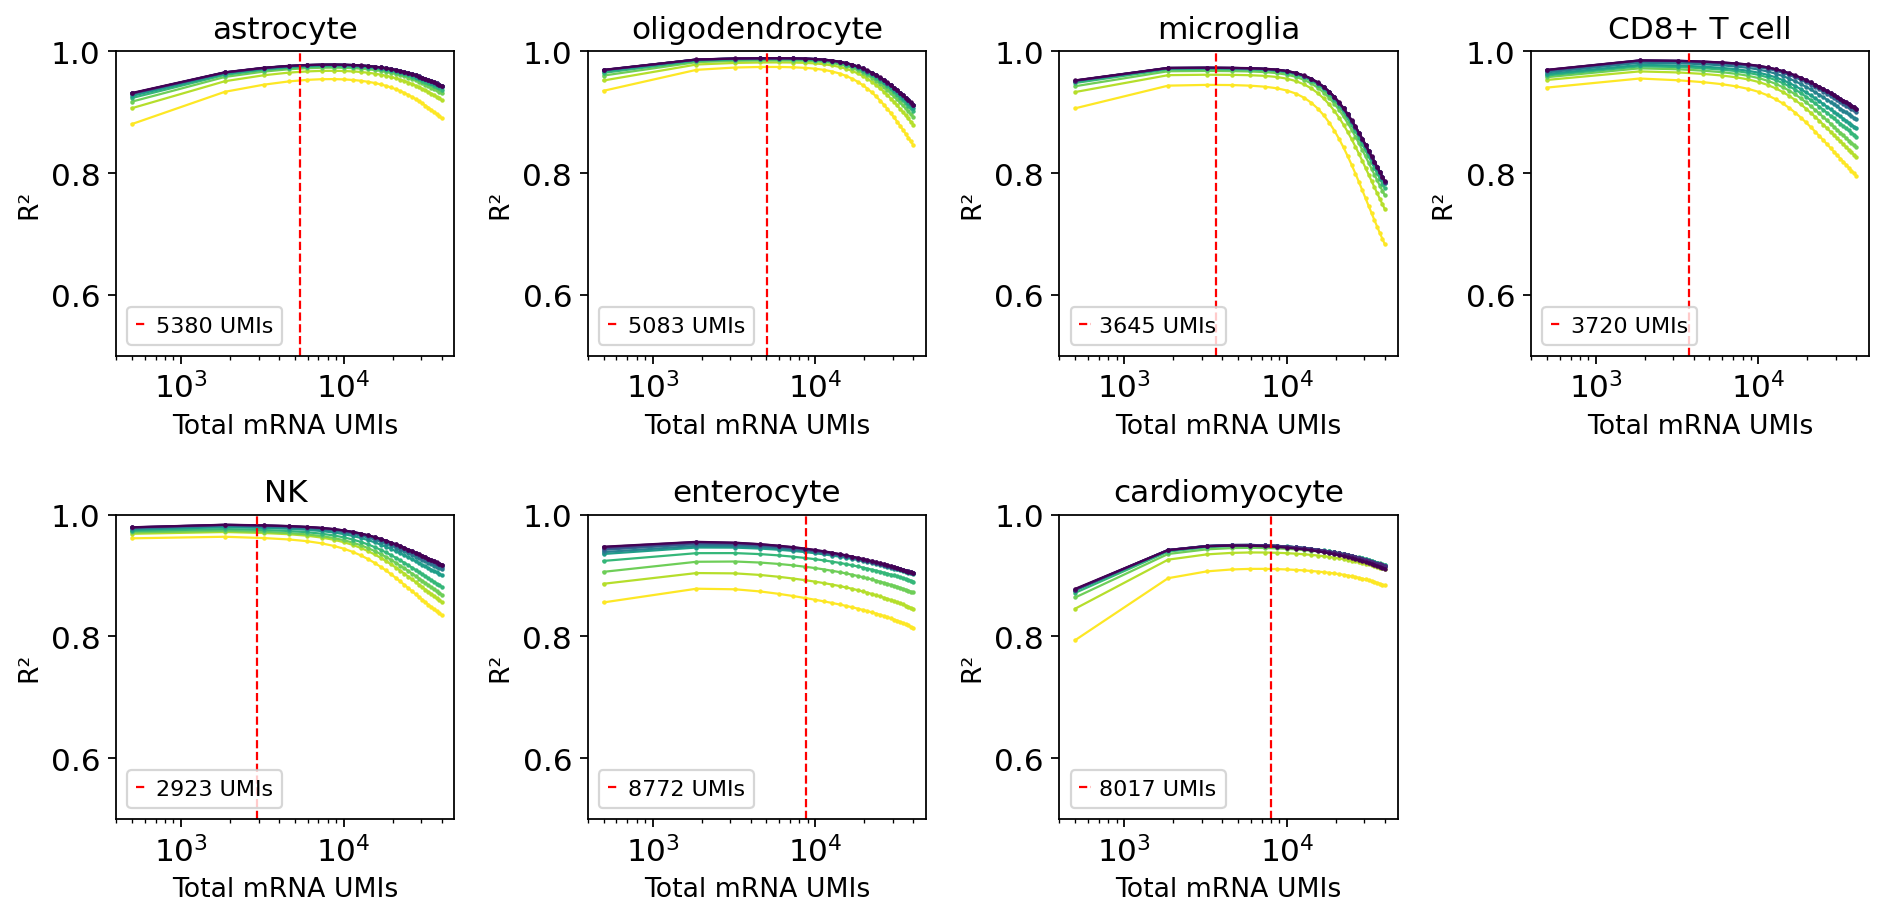

In [220]:
panel_size = 3
ncols = 4
nrows = n_cells // ncols + 1

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(panel_size * ncols, panel_size * nrows))

axs_flat = axs.flatten()
i_ax = 0

for n in range(n_cells):
    ax = axs_flat[i_ax]

    r_squared_bm = r_squared_bnm[:, n, :]

    for b in range(n_bins):
        color = plt.cm.viridis_r(b / (n_bins - 1))
        ax.plot(
            total_mrna_umis_list,
            r_squared_bm[b],
            color=color,
            # label=f"log1p(TPKC) bin {b + 1}",
            marker='.',
            markersize=2,
            lw=1)
    
    ax.axvline(
        x=val_adata.obs.iloc[val_cell_type_indices[n]].total_mrna_umis,
        color='red',
        linestyle='--',
        linewidth=1,
        label=f'{int(val_adata.obs.iloc[val_cell_type_indices[n]].total_mrna_umis)} UMIs'
    )
    ax.legend(loc='lower left', fontsize=10)
    ax.grid(False)
    ax.set_title(val_cell_type_names[n])
    ax.set_xlabel("Total mRNA UMIs", fontsize=12)
    ax.set_ylabel("R²", fontsize=12)
    ax.set_ylim((0.5, 1)) 
    ax.set_xlim((0.8 * min(total_mrna_umis_list), 1.2 * max(total_mrna_umis_list)))
    ax.set_xscale('log')

    i_ax += 1

for i_ax in range(i_ax, len(axs_flat)):
    axs_flat[i_ax].remove()

fig.tight_layout()